# Before your start:
- Read the README.md file
- Comment as much as you can and use the resources in the README.md file
- Happy learning!

In [2]:
# Import your libraries:

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Challenge 1 - Import and Describe the Dataset

In this lab, we will use a dataset containing information about customer preferences. We will look at how much each customer spends in a year on each subcategory in the grocery store and try to find similarities using clustering.

The origin of the dataset is [here](https://archive.ics.uci.edu/ml/datasets/wholesale+customers).

In [3]:
# loading the data:
customers = pd.read_csv('../Wholesale customers data.csv')

#### Explore the dataset with mathematical and visualization techniques. What do you find?

Checklist:

* What does each column mean?
* Any categorical data to convert?
* Any missing data to remove?
* Column collinearity - any high correlations?
* Descriptive statistics - any outliers to remove?
* Column-wise data distribution - is the distribution skewed?
* Etc.

Additional info: Over a century ago, an Italian economist named Vilfredo Pareto discovered that roughly 20% of the customers account for 80% of the typical retail sales. This is called the [Pareto principle](https://en.wikipedia.org/wiki/Pareto_principle). Check if this dataset displays this characteristic.

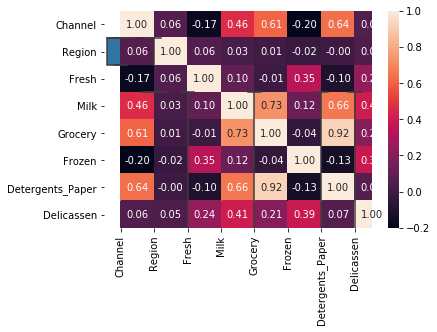

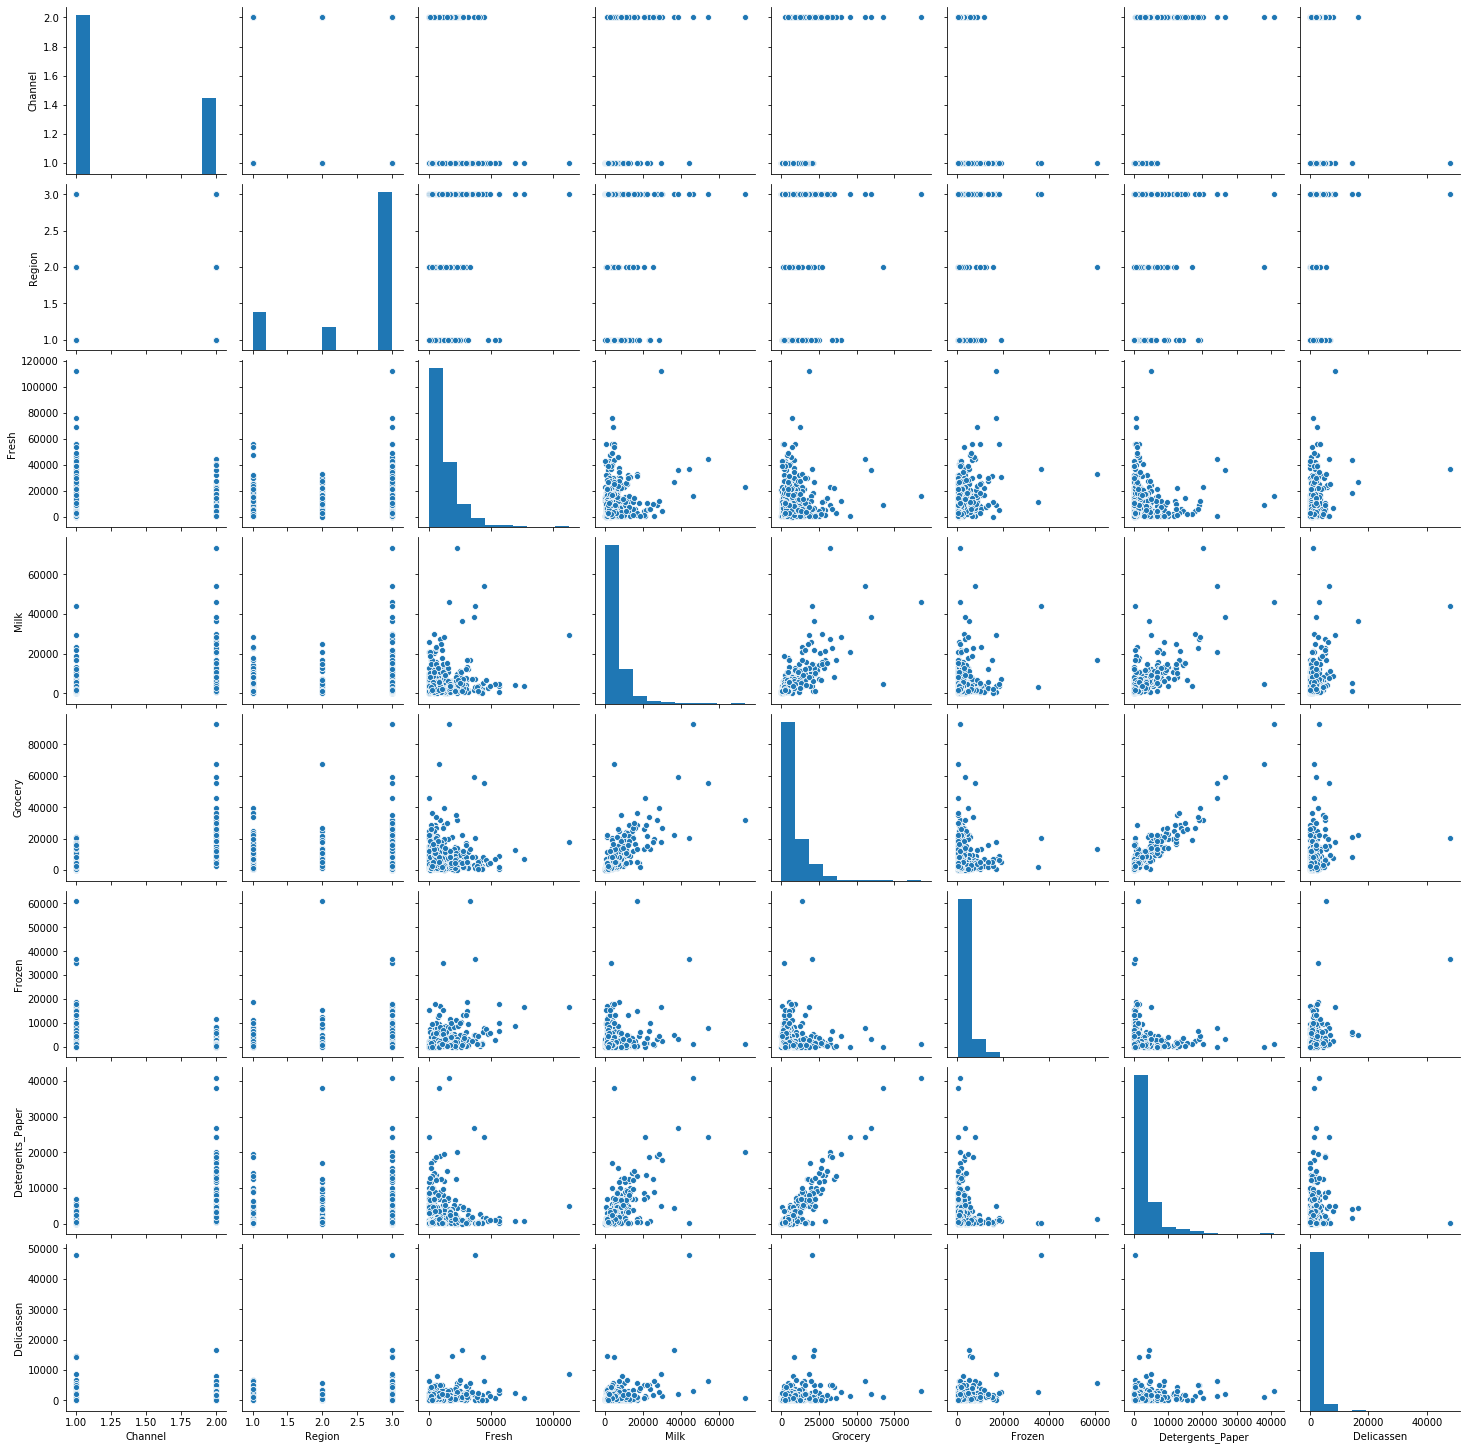

In [4]:
import seaborn as sns
customers.head(30) 
customers.dtypes
customers.isnull().sum()
sns.heatmap(customers.corr(),annot=True, fmt=".2f")
customers.describe()
sns.boxplot(data=customers)
sns.pairplot(customers)

##### Columns are quantities of sold goods
##### NO Categorical & Null values
##### Grocery & Detergent_Paper are highly correlated (>0.9) so one of them might be eliminated
##### Distributions for all goods are in general skewed towards lower values "exponential like".
##### There are potential outliers in every product column.

# Challenge 2 - Data Cleaning and Transformation

If your conclusion from the previous challenge is the data need cleaning/transformation, do it in the cells below. However, if your conclusion is the data need not be cleaned or transformed, feel free to skip this challenge. But if you do choose the latter, please provide rationale.

In [5]:
customers

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185
...,...,...,...,...,...,...,...,...
435,1,3,29703,12051,16027,13135,182,2204
436,1,3,39228,1431,764,4510,93,2346
437,2,3,14531,15488,30243,437,14841,1867
438,1,3,10290,1981,2232,1038,168,2125


In [6]:
customers_cleaned = customers.drop('Detergents_Paper', axis =1)

##### Since the dist are exponencial like I choose not to eliminate the outliers in the boxplot, probably not really outliers... 

# Challenge 3 - Data Preprocessing

One problem with the dataset is the value ranges are remarkably different across various categories (e.g. `Fresh` and `Grocery` compared to `Detergents_Paper` and `Delicassen`). If you made this observation in the first challenge, you've done a great job! This means you not only completed the bonus questions in the previous Supervised Learning lab but also researched deep into [*feature scaling*](https://en.wikipedia.org/wiki/Feature_scaling). Keep on the good work!

Diverse value ranges in different features could cause issues in our clustering. The way to reduce the problem is through feature scaling. We'll use this technique again with this dataset.

#### We will use the `StandardScaler` from `sklearn.preprocessing` and scale our data. Read more about `StandardScaler` [here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler).

*After scaling your data, assign the transformed data to a new variable `customers_scale`.*

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(customers_cleaned)
customers_scale = scaler.transform(customers_cleaned)
customers_scale

array([[ 1.44865163,  0.59066829,  0.05293319, ..., -0.04111489,
        -0.58936716, -0.06633906],
       [ 1.44865163,  0.59066829, -0.39130197, ...,  0.17031835,
        -0.27013618,  0.08915105],
       [ 1.44865163,  0.59066829, -0.44702926, ..., -0.0281571 ,
        -0.13753572,  2.24329255],
       ...,
       [ 1.44865163,  0.59066829,  0.20032554, ...,  2.34838631,
        -0.54337975,  0.12145607],
       [-0.69029709,  0.59066829, -0.13538389, ..., -0.60251388,
        -0.41944059,  0.21304614],
       [-0.69029709,  0.59066829, -0.72930698, ..., -0.57322717,
        -0.62009417, -0.52286938]])

# Challenge 4 - Data Clustering with K-Means

Now let's cluster the data with K-Means first. Initiate the K-Means model, then fit your scaled data. In the data returned from the `.fit` method, there is an attribute called `labels_` which is the cluster number assigned to each data record. What you can do is to assign these labels back to `customers` in a new column called `customers['labels']`. Then you'll see the cluster results of the original data.

In [8]:
from sklearn.cluster import KMeans

kmeans = KMeans()
km = kmeans.fit(customers_scale)
customers['labels'] = km.labels_

Count the values in `labels`.

In [9]:
customers['labels'].value_counts()

1    163
0     93
3     87
4     52
7     36
5      6
6      2
2      1
Name: labels, dtype: int64

# Challenge 5 - Data Clustering with DBSCAN

Now let's cluster the data using DBSCAN. Use `DBSCAN(eps=0.5)` to initiate the model, then fit your scaled data. In the data returned from the `.fit` method, assign the `labels_` back to `customers['labels_DBSCAN']`. Now your original data have two labels, one from K-Means and the other from DBSCAN.

In [10]:
from sklearn.cluster import DBSCAN

db_clustering = DBSCAN(eps=0.5)
db = db_clustering.fit(customers_scale)
customers['labels_DBSCAN'] = db.labels_
customers['labels_DBSCAN2'] = customers['labels_DBSCAN'] + 1
customers.loc[customers['labels_DBSCAN2'] == 0,'labels'].value_counts()

0    55
3    50
4    41
7    36
1    31
5     6
6     2
2     1
Name: labels, dtype: int64

Count the values in `labels_DBSCAN`.

In [25]:
customers['labels_DBSCAN'].value_counts()

-1    222
 2    138
 0     31
 4     23
 6      7
 5      7
 1      7
 3      5
Name: labels_DBSCAN, dtype: int64

# Challenge 6 - Compare K-Means with DBSCAN

Now we want to visually compare how K-Means and DBSCAN have clustered our data. We will create scatter plots for several columns. For each of the following column pairs, plot a scatter plot using `labels` and another using `labels_DBSCAN`. Put them side by side to compare. Which clustering algorithm makes better sense?

Columns to visualize:

* `Detergents_Paper` as X and `Milk` as y
* `Grocery` as X and `Fresh` as y
* `Frozen` as X and `Delicassen` as y

Visualize `Detergents_Paper` as X and `Milk` as y by `labels` and `labels_DBSCAN` respectively

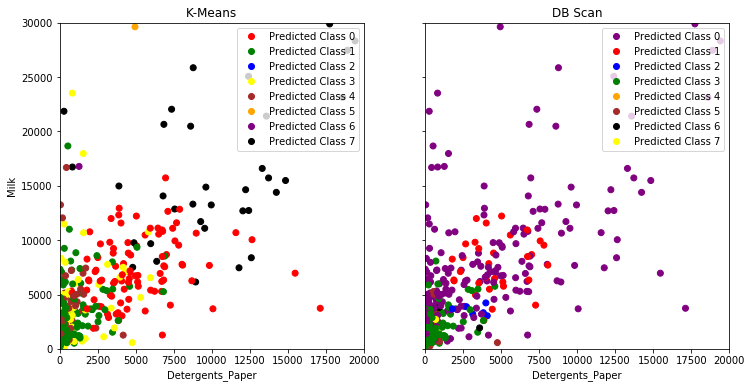

In [12]:
from matplotlib.lines import Line2D

fig, axs = plt.subplots(1,2, figsize= (12,6), sharey = True)

colors =  np.array(['Red', 'Green', 'Blue', 'Yellow', 'Brown', 'Orange', 'Purple', 'Black'])
colors2 = np.array(['Purple', 'Red', 'Blue', 'Green', 'Orange', 'Brown', 'Black', 'Yellow'])

legend_elems = [Line2D([0], [0], color=color, marker='o', linestyle='', label="Predicted Class {}".format(i))
                for i, color in enumerate(colors)]

legend_elems2 = [Line2D([0], [0], color=color, marker='o', linestyle='', label="Predicted Class {}".format(i))
                for i, color in enumerate(colors2)]

new_db_labels_ = db.labels_ + 1

axs[0].scatter(customers.Detergents_Paper, customers.Milk, color = colors[km.labels_])
axs[0].set_xlabel('Detergents_Paper')
axs[0].set_ylabel('Milk')
axs[0].legend(handles=legend_elems, loc='upper right')
axs[0].set_title('K-Means')
axs[0].set_xlim(0,20000)
axs[0].set_ylim(0,30000)

axs[1].scatter(customers.Detergents_Paper, customers.Milk, color = colors2[new_db_labels_])
axs[1].set_xlabel('Detergents_Paper')
axs[1].legend(handles=legend_elems2, loc='upper right')
axs[1].set_title('DB Scan')
axs[1].set_xlim(0,20000)

plt.show()

Visualize `Grocery` as X and `Fresh` as y by `labels` and `labels_DBSCAN` respectively

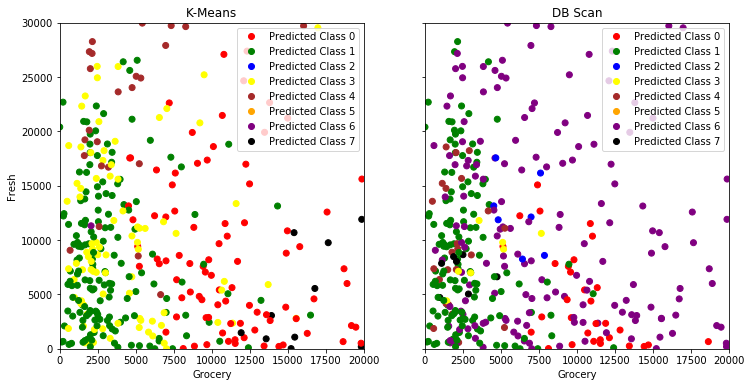

In [13]:
from matplotlib.lines import Line2D

fig, axs = plt.subplots(1,2, figsize= (12,6), sharey = True)

colors =  np.array(['Red', 'Green', 'Blue', 'Yellow', 'Brown', 'Orange', 'Purple', 'Black'])
colors2 = np.array(['Purple', 'Red', 'Blue', 'Green', 'Orange', 'Brown', 'Black', 'Yellow'])

legend_elems = [Line2D([0], [0], color=color, marker='o', linestyle='', label="Predicted Class {}".format(i))
                for i, color in enumerate(colors)]

legend_elems2 = [Line2D([0], [0], color=color, marker='o', linestyle='', label="Predicted Class {}".format(i))
                for i, color in enumerate(colors2)]

new_db_labels_ = db.labels_ + 1


axs[0].scatter(customers.Grocery, customers.Fresh, color = colors[km.labels_])
axs[0].set_xlabel('Grocery')
axs[0].set_ylabel('Fresh')
axs[0].legend(handles=legend_elems, loc='upper right')
axs[0].set_title('K-Means')
axs[0].set_xlim(0,20000)
axs[0].set_ylim(0,30000)

axs[1].scatter(customers.Grocery, customers.Fresh, color = colors2[new_db_labels_])
axs[1].set_xlabel('Grocery')
axs[1].legend(handles=legend_elems, loc='upper right')
axs[1].set_title('DB Scan')
axs[1].set_xlim(0,20000)

plt.show()

Visualize `Frozen` as X and `Delicassen` as y by `labels` and `labels_DBSCAN` respectively

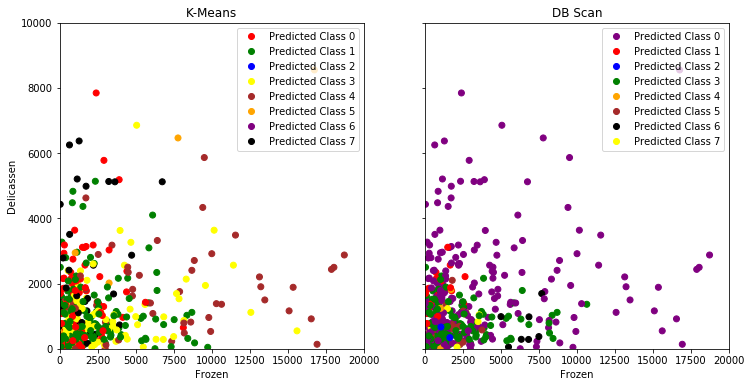

In [14]:
from matplotlib.lines import Line2D

fig, axs = plt.subplots(1,2, figsize= (12,6), sharey = True)

colors =  np.array(['Red', 'Green', 'Blue', 'Yellow', 'Brown', 'Orange', 'Purple', 'Black'])
colors2 = np.array(['Purple', 'Red', 'Blue', 'Green', 'Orange', 'Brown', 'Black', 'Yellow'])

legend_elems = [Line2D([0], [0], color=color, marker='o', linestyle='', label="Predicted Class {}".format(i))
                for i, color in enumerate(colors)]

legend_elems2 = [Line2D([0], [0], color=color, marker='o', linestyle='', label="Predicted Class {}".format(i))
                for i, color in enumerate(colors2)]

new_db_labels_ = db.labels_ + 1

axs[0].scatter(customers.Frozen, customers.Delicassen, color = colors[km.labels_])
axs[0].set_xlabel('Frozen')
axs[0].set_ylabel('Delicassen')
axs[0].legend(handles=legend_elems, loc='upper right')
axs[0].set_title('K-Means')
axs[0].set_xlim(0,20000)
axs[0].set_ylim(0,10000)

axs[1].scatter(customers.Frozen, customers.Delicassen, color = colors2[new_db_labels_])
axs[1].set_xlabel('Frozen')
axs[1].legend(handles=legend_elems2, loc='upper right')
axs[1].set_title('DB Scan')
axs[1].set_xlim(0,20000)

plt.show()

Let's use a groupby to see how the mean differs between the groups. Group `customers` by `labels` and `labels_DBSCAN` respectively and compute the means for all columns.

In [15]:
customers.groupby('labels').mean()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,labels_DBSCAN,labels_DBSCAN2
labels,,,,,,,,,,
0,2.000000,2.892473,8501.548387,7300.333333,11707.752688,1371.333333,5203.913978,1417.634409,-0.516129,0.483871
1,1.000000,3.000000,8350.711656,2830.932515,3381.723926,2121.404908,796.030675,957.895706,1.429448,2.429448
2,1.000000,3.000000,36847.000000,43950.000000,20170.000000,36534.000000,239.000000,47943.000000,-1.000000,0.000000
3,1.068966,1.298851,10111.091954,3301.908046,4235.747126,3089.057471,972.000000,1080.827586,1.367816,2.367816
4,1.057692,2.807692,32891.750000,3965.519231,4867.115385,7380.442308,726.884615,2236.423077,-0.269231,0.730769
5,1.833333,3.000000,42995.666667,46395.500000,46705.000000,5824.666667,20175.666667,6233.666667,-1.000000,0.000000
6,1.000000,2.500000,22015.500000,9937.000000,7844.000000,47939.000000,671.500000,4153.500000,-1.000000,0.000000
7,1.972222,2.111111,5539.805556,15953.166667,25578.666667,1623.222222,11365.055556,2194.111111,-1.000000,0.000000


In [16]:
customers.groupby('labels_DBSCAN').mean()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,labels,labels_DBSCAN2
labels_DBSCAN,,,,,,,,,,
-1,1.468468,2.396396,14848.144144,8729.409910,11932.941441,4180.045045,4482.184685,2222.193694,2.887387,0.0
0,2.000000,3.000000,4580.290323,7785.032258,10442.096774,803.354839,4613.419355,1400.516129,0.000000,1.0
1,2.000000,3.000000,12530.857143,3213.000000,6117.857143,868.571429,2879.571429,350.857143,0.000000,2.0
2,1.000000,3.000000,8835.507246,2004.289855,2751.543478,2100.775362,629.253623,740.869565,1.130435,3.0
3,1.000000,3.000000,41446.600000,1421.200000,2167.600000,1276.400000,416.200000,784.800000,4.000000,4.0
4,1.000000,1.000000,9491.391304,1700.782609,2092.565217,1488.695652,526.478261,648.782609,3.000000,5.0
5,1.000000,1.000000,7059.000000,1941.285714,2302.714286,6526.571429,844.571429,667.000000,3.000000,6.0
6,1.000000,2.000000,8555.714286,1742.285714,4017.142857,2354.428571,385.714286,855.571429,3.000000,7.0


In [24]:
from sklearn.metrics import silhouette_score

print(silhouette_score (customers_scale,km.labels_))
print(silhouette_score (customers_scale,db.labels_))

0.36866603382153873
-0.05141275867218122


Which algorithm appears to perform better?

##### Silhouette Score is better for K-MEans, so this  is probably better.

# Bonus Challenge 1 - Changing K-Means Number of Clusters

As we mentioned earlier, we don't need to worry about the number of clusters with DBSCAN because it automatically decides that based on the parameters we send to it. But with K-Means, we have to supply the `n_clusters` param (if you don't supply `n_clusters`, the algorithm will use `8` by default). You need to know that the optimal number of clusters differs case by case based on the dataset. K-Means can perform badly if the wrong number of clusters is used.

In advanced machine learning, data scientists try different numbers of clusters and evaluate the results with statistical measures (read [here](https://en.wikipedia.org/wiki/Cluster_analysis#External_evaluation)). We are not using statistical measures today but we'll use our eyes instead. In the cells below, experiment with different number of clusters and visualize with scatter plots. What number of clusters seems to work best for K-Means?

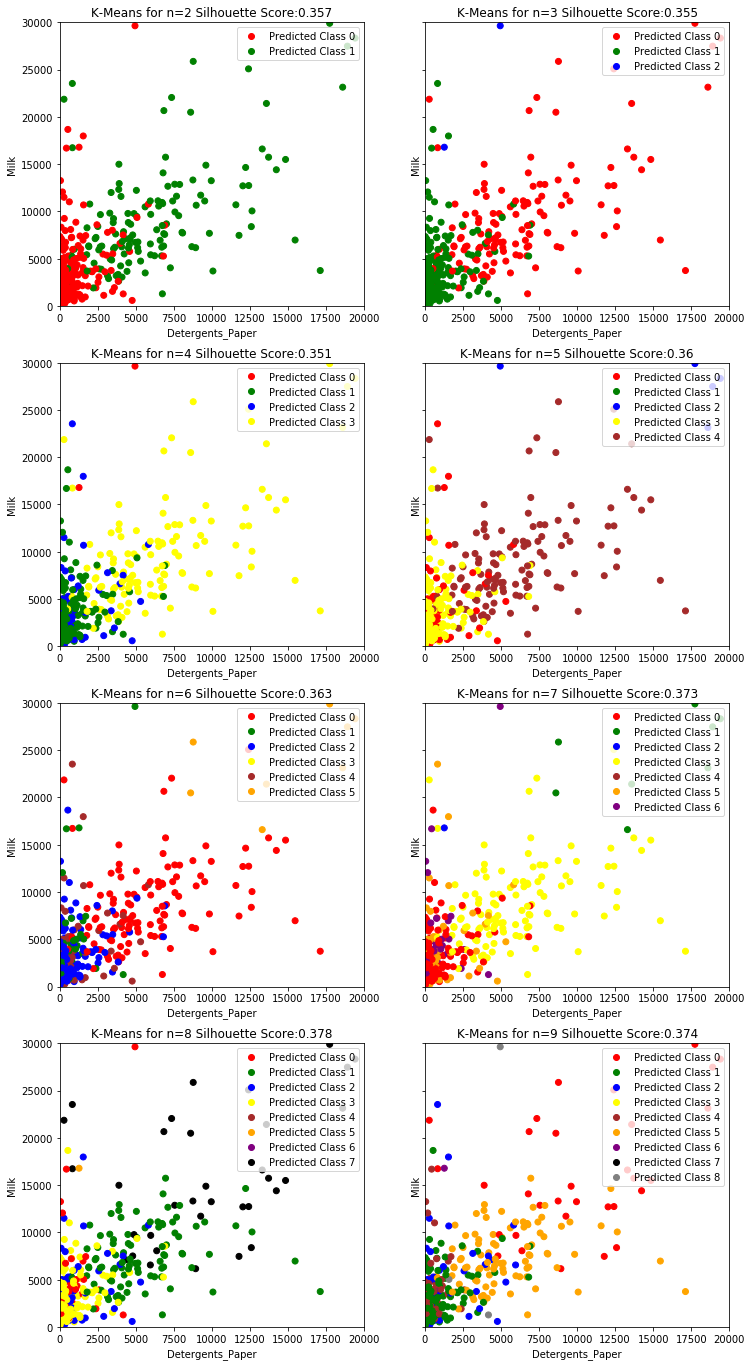

In [38]:
fig, axs = plt.subplots(4,2, figsize= (12,24), sharey = True)

colors =  np.array(['Red', 'Green', 'Blue', 'Yellow', 'Brown', 'Orange', 'Purple', 'Black', 'Grey'])

labels=[]

for n in range(2,10,1):
    kmeans2 = KMeans(n_clusters=n).fit(customers_scale)
    labels.append(kmeans2.labels_)

for i,ax in enumerate(axs.reshape(-1)):  
    ax.scatter(customers.Detergents_Paper, customers.Milk, color = colors[labels[i]])
    ax.set_xlabel('Detergents_Paper')
    ax.set_ylabel('Milk')
    legend_elems = [Line2D([0], [0], color=color, marker='o', linestyle='', label="Predicted Class {}".format(i))
                for i, color in enumerate(colors[:i+2])]
    ax.legend(handles=legend_elems, loc='upper right')
    ss =  silhouette_score (customers_scale,labels[i])
    title = 'K-Means for n=' + str(i+2) + ' Silhouette Score:' + str(round(ss,3))
    ax.set_title(title)
    ax.set_xlim(0,20000)
    ax.set_ylim(0,30000)

plt.show()

##### From the silhouette score n = 8 seems to be the best

# Bonus Challenge 2 - Changing DBSCAN `eps` and `min_samples`

Experiment changing the `eps` and `min_samples` params for DBSCAN. See how the results differ with scatter plot visualization.

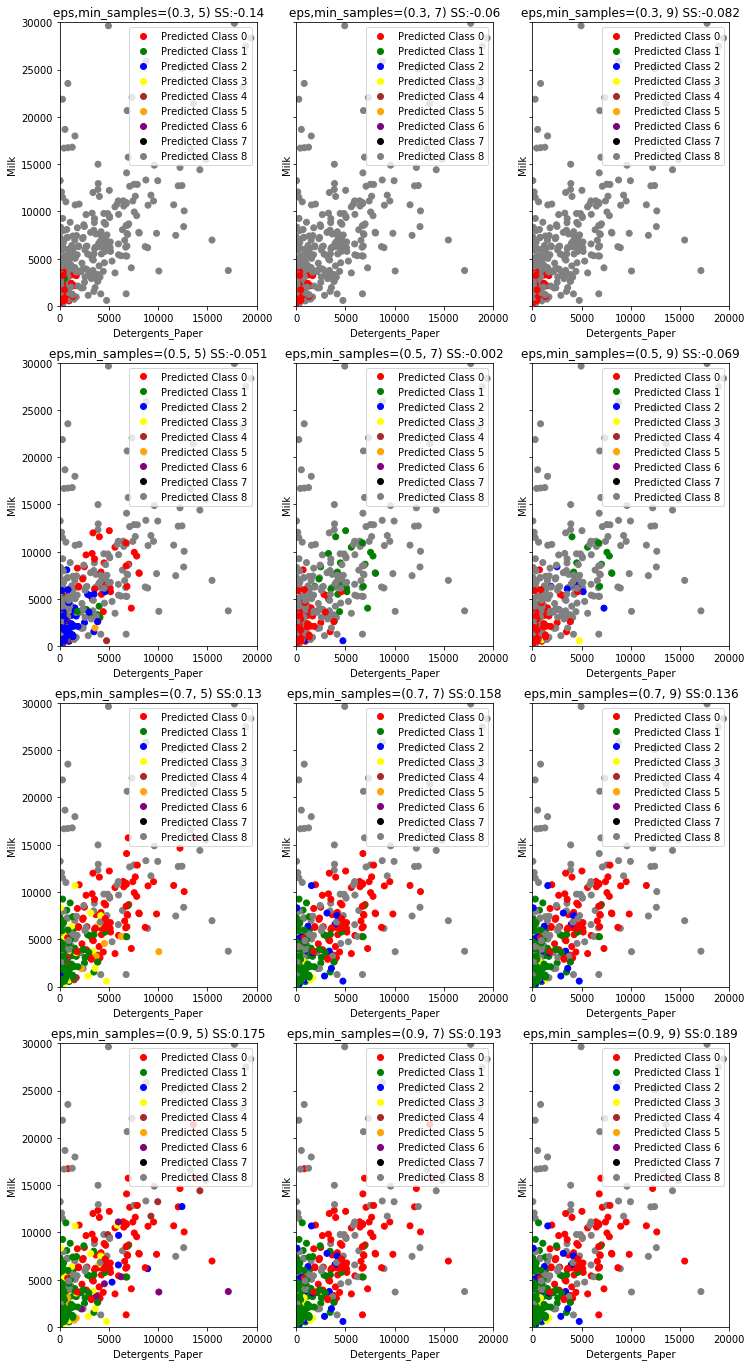

In [55]:
from sklearn.pipeline import make_pipeline

eps = [0.3,0.5,0.7,0.9]
min_samples =[5,7,9]

labels_dict ={}

for ep in eps:
    for samples in min_samples:
        model = DBSCAN(eps=ep, min_samples=samples).fit(customers_scale)
        labels_dict[(ep,samples)] = model.labels_

param_comb = list(labels_dict.keys())
param_values = list(labels_dict.values())

fig, axs = plt.subplots(4,3, figsize= (12,24), sharey = True)

colors =  np.array(['Red', 'Green', 'Blue', 'Yellow', 'Brown', 'Orange', 'Purple', 'Black', 'Grey'])

for i,ax in enumerate(axs.reshape(-1)):
    ax.scatter(customers.Detergents_Paper, customers.Milk, color = colors[param_values[i]])
    ax.set_xlabel('Detergents_Paper')
    ax.set_ylabel('Milk')
    legend_elems = [Line2D([0], [0], color=color, marker='o', linestyle='', label="Predicted Class {}".format(i))
                for i, color in enumerate(colors)]
    ax.legend(handles=legend_elems, loc='upper right')
    ss =  silhouette_score (customers_scale,param_values[i])
    title = 'eps,min_samples=' + str(param_comb[i]) + ' SS:' + str(round(ss,3))
    ax.set_title(title)
    ax.set_xlim(0,20000)
    ax.set_ylim(0,30000)

plt.show()

##### For the combinatins tested and given the SS values obtained I would go with eps = 0.9 amd min_samples = 7